**Introduction:** 

**Methods:** 

In [1]:
# Install required packages (only run once per environment)
%pip install pandas matplotlib seaborn matplotlib-venn pybedtools
%pip install pyranges

# Imports
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pybedtools
from pybedtools import BedTool
from matplotlib_venn import venn2, venn2_circles, layout
import pyranges as pr
import zipfile

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Figure 2


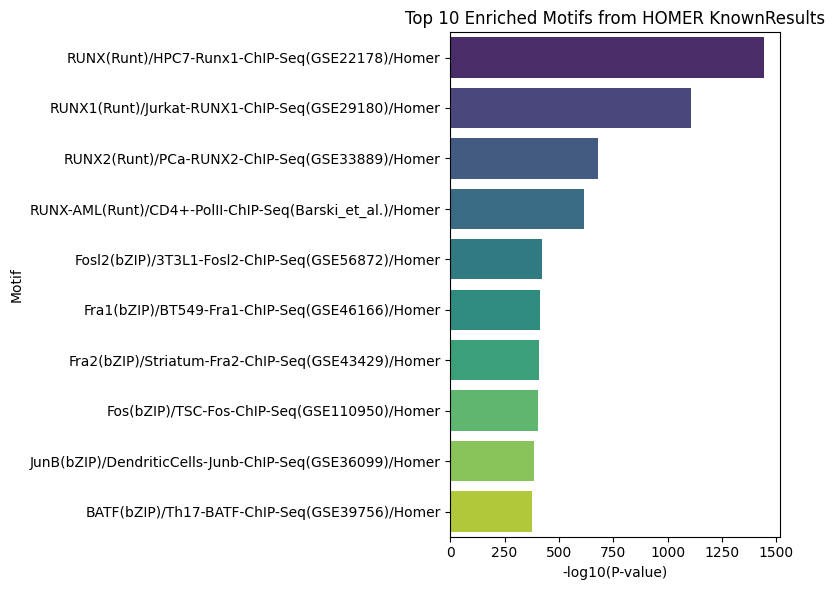

In [9]:
# Load the knownResults.txt file
df = pd.read_csv('/projectnb/bf528/students/agover11/project-3-agover11/results/motifs/knownResults.txt', sep='\t')

# Use absolute value of Log P-value for plotting (convert to positive)
df['abs_logP'] = df['Log P-value'].abs()

# Select top 10 motifs by P-value (smallest)
top_motifs = df.nsmallest(10, 'P-value').copy()

plt.figure(figsize=(8,6))
sns.barplot(
    data=top_motifs, 
    y='Motif Name', 
    x='abs_logP', 
    hue='Motif Name',  # add hue
    dodge=False,        # prevent bars from splitting
    palette='viridis',
    legend=False        # optional: remove legend
)
plt.xlabel('-log10(P-value)')
plt.ylabel('Motif')
plt.title('Top 10 Enriched Motifs from HOMER KnownResults')
plt.tight_layout()
plt.show()

In [3]:
def get_fastq_total_sequences(zip_path):
    try:
        with zipfile.ZipFile(zip_path) as z:
            # Find the fastqc_data.txt file inside any folder within the zip
            file_name = None
            for name in z.namelist():
                if name.endswith('fastqc_data.txt'):
                    file_name = name
                    break
            
            if file_name is None:
                print(f"fastqc_data.txt not found in {zip_path}")
                return None
            
            with z.open(file_name) as f:
                for line in f:
                    line = line.decode('utf-8').strip()
                    if line.startswith('Total Sequences'):
                        parts = line.split('\t')
                        if len(parts) < 2:
                            print(f"Unexpected format for 'Total Sequences' line in {zip_path}")
                            return None
                        return int(parts[1])
    except Exception as e:
        print(f"Error reading {zip_path}: {e}")
        return None
    return None

def get_mapped_reads(flagstat_path):
    try:
        with open(flagstat_path, 'r') as f:
            for line in f:
                if " mapped (" in line and "primary" not in line:
                    parts = line.split()
                    if parts:
                        try:
                            return int(parts[0])
                        except ValueError:
                            print(f"Could not convert mapped read count to int in {flagstat_path}")
                            return None
    except Exception as e:
        print(f"Error reading {flagstat_path}: {e}")
        return None
    return None

samples = {
    'IP_rep1': {
        'fastqc': '/projectnb/bf528/students/agover11/project-3-agover11/results/IP_rep1_fastqc.zip',
        'flagstat': '/projectnb/bf528/students/agover11/project-3-agover11/results/IP_rep1_flagstat.txt'
    },
    'IP_rep2': {
        'fastqc': '/projectnb/bf528/students/agover11/project-3-agover11/results/IP_rep2_fastqc.zip',
        'flagstat': '/projectnb/bf528/students/agover11/project-3-agover11/results/IP_rep2_flagstat.txt'
    },
    'INPUT_rep1': {
        'fastqc': '/projectnb/bf528/students/agover11/project-3-agover11/results/INPUT_rep1_fastqc.zip',
        'flagstat': '/projectnb/bf528/students/agover11/project-3-agover11/results/INPUT_rep1_flagstat.txt'
    },
    'INPUT_rep2': {
        'fastqc': '/projectnb/bf528/students/agover11/project-3-agover11/results/INPUT_rep2_fastqc.zip',
        'flagstat': '/projectnb/bf528/students/agover11/project-3-agover11/results/INPUT_rep2_flagstat.txt'
    }
}

data = []
for sample_name, paths in samples.items():
    raw_reads = get_fastq_total_sequences(paths['fastqc'])
    mapped_reads = get_mapped_reads(paths['flagstat'])

    if raw_reads is None or mapped_reads is None:
        print(f"Warning: missing data for {sample_name}")

    # Extract biological replicate number (e.g. rep1 -> 1)
    replicate = int(sample_name.split('_rep')[1])
    
    data.append({
        'Sample Name': sample_name,
        'Biological Replicate': replicate,
        'Raw Reads': raw_reads,
        'Mapped Reads': mapped_reads
    })

df = pd.DataFrame(data)

# Format counts with commas for readability
df['Raw Reads'] = df['Raw Reads'].map('{:,}'.format)
df['Mapped Reads'] = df['Mapped Reads'].map('{:,}'.format)

print("Figure 3:")
df

Figure 3:


,Sample Name,Biological Replicate,Raw Reads,Mapped Reads
0,IP_rep1,1,"29,734,121","27,788,333"
1,IP_rep2,2,"29,988,988","28,197,249"
2,INPUT_rep1,1,"30,075,142","28,578,769"
3,INPUT_rep2,2,"10,900,442","10,055,226"


Rep1 peaks: 89360
Rep2 peaks: 22897
Unique Rep1 peaks: 82898
Unique Rep2 peaks: 16435
Overlapping peaks: 6462
Figure 5


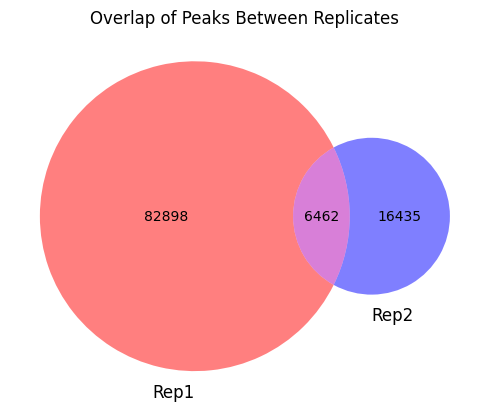

In [11]:
# Load HOMER peaks

def load_homer_peaks(file_path):
    df = pd.read_csv(
        file_path,
        sep='\t',
        comment='#',  # skip all header lines
        header=None,
        names=['Chromosome','Start','End','PeakID','Score','Strand'],
        engine='python'
    )
    return df

rep1 = load_homer_peaks("/projectnb/bf528/students/agover11/project-3-agover11/results/rep1_peaks.bed")
rep2 = load_homer_peaks("/projectnb/bf528/students/agover11/project-3-agover11/results/rep2_peaks.bed")

print(f"Rep1 peaks: {len(rep1)}")
print(f"Rep2 peaks: {len(rep2)}")

# Convert to PyRanges objects
pr1 = pr.PyRanges(rep1)
pr2 = pr.PyRanges(rep2)

# Find overlapping peaks
intersection = pr1.join(pr2)

# Counts
intersection_count = len(intersection)
unique_rep1 = len(pr1) - intersection_count
unique_rep2 = len(pr2) - intersection_count

print(f"Unique Rep1 peaks: {unique_rep1}")
print(f"Unique Rep2 peaks: {unique_rep2}")
print(f"Overlapping peaks: {intersection_count}")

# Plot Venn diagram
venn2(subsets=(unique_rep1, unique_rep2, intersection_count), 
      set_labels=('Rep1', 'Rep2'), 
      set_colors=('red', 'blue'),
      alpha=0.5) 
      
print("Figure 5")
plt.title('Overlap of Peaks Between Replicates')
plt.show()

In [12]:
rna_path = "/projectnb/bf528/students/agover11/project-3-agover11/GSE75070_RNAseq.txt"
rna_df = pd.read_csv(rna_path, sep='\t')

In [13]:
anno_path = "/projectnb/bf528/students/agover11/project-3-agover11/results/annotated_peaks.txt"

anno_df = pd.read_csv(anno_path, sep='\t', comment='#', low_memory=False)
anno_df.to_csv("annotated_peaks.csv", index=False)

anno_df = pd.read_csv("annotated_peaks.csv")

/scratch/1615927.1.academic/ipykernel_2118912/2670746721.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sig["in_5kb_tss"] = sig["in_5kb_tss"].fillna(False)
/scratch/1615927.1.academic/ipykernel_2118912/2670746721.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sig["in_20kb_gene"] = sig["in_20kb_gene"].fillna(False)


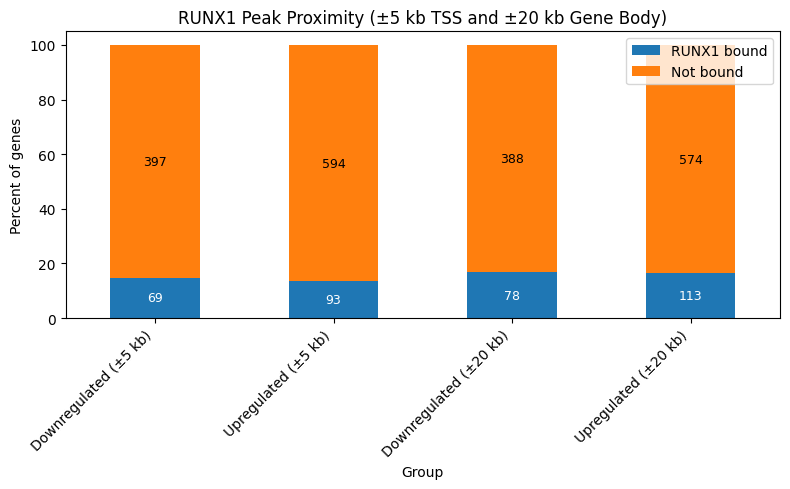

In [14]:
# Define peak proximity windows
anno_df["in_5kb_tss"] = anno_df["Distance to TSS"].between(-5000, 5000)
anno_df["in_20kb_gene"] = anno_df["Distance to TSS"].between(-20000, 20000)

# -----------------------------
# Collapse peaks per gene
# -----------------------------
gene_peak_df = anno_df.groupby("Gene Name").agg(
    in_5kb_tss=("in_5kb_tss", "any"),
    in_20kb_gene=("in_20kb_gene", "any")
).reset_index()

# -----------------------------
# Merge RNA-seq + gene-level peak info
# -----------------------------
merged = rna_df.merge(
    gene_peak_df,
    left_on="genename",
    right_on="Gene Name",
    how="left"
)

# -----------------------------
# Filter significant RNAseq genes
# -----------------------------
sig = merged[(merged["padj"] < 0.01) & (merged["log2FoldChange"].abs() > 1)].copy()
sig["direction"] = sig["log2FoldChange"].apply(lambda x: "Upregulated" if x > 0 else "Downregulated")

# Fill NaNs for genes with no peaks
sig["in_5kb_tss"] = sig["in_5kb_tss"].fillna(False)
sig["in_20kb_gene"] = sig["in_20kb_gene"].fillna(False)

# -----------------------------
# Compute percentages for plotting
# -----------------------------
def percent_bound(df, column):
    counts = df.groupby("direction")[column].value_counts().unstack().fillna(0)
    counts_pct = counts.div(counts.sum(axis=1), axis=0) * 100
    return counts_pct.rename(columns={True: "RUNX1 bound", False: "Not bound"}), counts

pct_5kb, counts_5kb = percent_bound(sig, "in_5kb_tss")
pct_20kb, counts_20kb = percent_bound(sig, "in_20kb_gene")

# -----------------------------
# Prepare plotting dataframe
# -----------------------------
plot_df = pd.concat([
    pct_5kb.assign(Window="±5 kb"),
    pct_20kb.assign(Window="±20 kb")
]).reset_index()

# Add counts for labeling
plot_df = plot_df.merge(
    pd.concat([
        counts_5kb.assign(Window="±5 kb"),
        counts_20kb.assign(Window="±20 kb")
    ]).reset_index().rename(columns={True: "RUNX1 bound count", False: "Not bound count"}),
    on=["direction","Window"]
)

plot_df["Group"] = plot_df["direction"] + " (" + plot_df["Window"] + ")"
plot_df = plot_df.set_index("Group")[["RUNX1 bound", "Not bound", "RUNX1 bound count", "Not bound count"]]

# -----------------------------
# Plot
# -----------------------------
ax = plot_df[["RUNX1 bound", "Not bound"]].plot(
    kind="bar",
    stacked=True,
    figsize=(8,5),
    ylabel="Percent of genes",
    title="RUNX1 Peak Proximity (±5 kb TSS and ±20 kb Gene Body)",
    color=["#1f77b4","#ff7f0e"]
)

plt.xticks(rotation=45, ha="right")

# Add gene counts inside the bar segments
for idx, row in plot_df.iterrows():
    x = ax.get_xticks()[list(plot_df.index).index(idx)]
    
    # RUNX1 bound (bottom segment) - white text
    ax.text(
        x=x,
        y=row["RUNX1 bound"]/2,  # center of bottom segment
        s=int(row["RUNX1 bound count"]),
        ha="center",
        va="center",
        fontsize=9,
        color="white"
    )
    
    # Not bound (top segment) - black text
    ax.text(
        x=x,
        y=row["RUNX1 bound"] + row["Not bound"]/2,  # center of top segment
        s=int(row["Not bound count"]),
        ha="center",
        va="center",
        fontsize=9,
        color="black"
    )

plt.tight_layout()
plt.show()